In [30]:
# Import dependencies
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.client import device_lib
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [31]:
# Print TensorFlow version
print("The version of TensorFlow is:", tf.__version__)

The version of TensorFlow is: 1.10.0


In [32]:
# Check local devices
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3410479384407728056
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5075169280
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11940516093853440171
physical_device_desc: "device: 0, name: GeForce GTX 980 Ti, pci bus id: 0000:01:00.0, compute capability: 5.2"
]


In [33]:
# Load data
mnist = tf.keras.datasets.mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

In [34]:
type(X_train)

numpy.ndarray

In [35]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


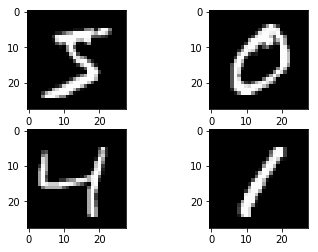

In [36]:
# Show sample figures
plt.subplot(221)
plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train[3], cmap=plt.get_cmap('gray'))
# Show the plot
plt.show()

In [37]:
# Need to reshape x data
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], num_pixels).astype("float32")
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype("float32")

In [38]:
print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


In [39]:
# Normalize the x data
X_train, X_test = X_train / 255.0, X_test / 255.0

In [40]:
Y_train[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

In [41]:
# One Hot encoding
Y_train_oh = to_categorical(Y_train)
Y_test_oh = to_categorical(Y_test)

In [42]:
print(Y_train_oh.shape)
print(Y_test_oh.shape)

(60000, 10)
(10000, 10)


In [43]:
# Split the train set into a new train set and a dev set
X_train, X_dev, Y_train_oh, Y_dev_oh = train_test_split(
                                X_train, Y_train_oh, test_size=5000, random_state=23
)

In [44]:
print(X_train.shape)
print(X_dev.shape)
print(Y_train_oh.shape)
print(Y_dev_oh.shape)

(55000, 784)
(5000, 784)
(55000, 10)
(5000, 10)


In [45]:
# Data dimensions
img_size_flat = X_train.shape[1]
n_classes = Y_train_oh.shape[1]
print(img_size_flat)
print(n_classes)

784
10


In [46]:
# Define our Neural Network
class Network():
    def __init__(self, X_train, Y_train_oh, X_dev, Y_dev_oh, batch_size_train, n_epochs=100, lr=0.1):
        """
        m_train: number of training samples
        """
        # Hyperparameters
        self.X_train = X_train
        self.Y_train_oh = Y_train_oh
        self.X_dev = X_dev
        self.Y_dev_oh = Y_dev_oh
        self.m_train = self.X_train.shape[0]
        self.batch_size_train = batch_size_train
        self.n_batches = self.m_train // self.batch_size_train
        self.n_epochs = n_epochs
        self.lr = lr
        
        # Graph related
        self.graph = tf.Graph()
        self.X = None
        self.Y_oh = None
        
        # Initialize
        self.define_graph()
        self.session = tf.Session(graph=self.graph)
        
    def define_graph(self):
        with self.graph.as_default():
            self.X = tf.placeholder(tf.float32, (None, img_size_flat))
            self.Y_oh = tf.placeholder(tf.float32, (None, n_classes))
            
            # Variables to be optimized
            self.Weights = {
                            'W_1': tf.Variable(tf.truncated_normal((img_size_flat, 689), stddev=0.1)), # Hidden layer 1
                            'W_2': tf.Variable(tf.truncated_normal((689, 689), stddev=0.1)), # Hidden layer2
                            'W_3': tf.Variable(tf.truncated_normal((689, n_classes), stddev=0.1)) # Output layer (layer 3)
                            } 
            
            self.biases = {
                           'b_1': tf.Variable(tf.zeros((1, 689)) + 0.1), # Hidden layer 1
                           'b_2': tf.Variable(tf.zeros((1, 689)) + 0.1), # Hidden layer 2
                           'b_3': tf.Variable(tf.zeros((1, n_classes)) + 0.1) # Output layer (layer 3)
                           } 
            
            # Calculations
            def model(X):
                # Hidden layer 1
                Z_1 = tf.matmul(X, self.Weights['W_1']) + self.biases['b_1']
                A_1 = tf.nn.relu(Z_1)
                # Hidden layer 2
                Z_2 = tf.matmul(A_1, self.Weights['W_2']) + self.biases['b_2']
                A_2 = tf.nn.relu(Z_2)
                # Output layer (layer 3)
                Z_3 = tf.matmul(A_2, self.Weights['W_3']) + self.biases['b_3']
                
                return Z_3
            
            # Training
            self.logits = model(self.X)
            self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.logits, labels=self.Y_oh))
                
            # Optimizer
            self.optimizer = tf.train.GradientDescentOptimizer(self.lr).minimize(self.cost)
            
            # Predictions
            self.Y_pred = tf.nn.softmax(self.logits)
            self.correct_prediction = tf.equal(tf.argmax(self.Y_oh, 1), tf.arg_max(self.Y_pred, 1))
            self.accuracy = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))
    
    def run(self):
        with self.session as sess:
            tf.initialize_all_variables().run()
            avg_cost_list = []
            acc_list = []
            # Loop through epochs
            for epoch in range(self.n_epochs):
                avg_cost = 0
                # Shuffle the train data
                s = np.arange(self.m_train)
                np.random.shuffle(s)
                self.X_train = self.X_train[s]
                self.Y_train_oh = self.Y_train_oh[s]
                # Loop through mini-batches
                for batch in range(self.n_batches + 1):
                    # Generate mini-batch data
                    if batch < self.n_batches:
                        X_batch = self.X_train[(0 + batch * self.batch_size_train):(self.batch_size_train + batch * self.batch_size_train)]
                        Y_oh_batch = self.Y_train_oh[(0 + batch * self.batch_size_train):(self.batch_size_train + batch * self.batch_size_train)]
                    else:
                        # Use the rest of the data
                        X_batch = self.X_train[(self.n_batches * self.batch_size_train):self.m_train]
                        Y_oh_batch = self.Y_train_oh[(self.n_batches * self.batch_size_train):self.m_train]
                    feed_dict_train = {
                        self.X: X_batch,
                        self.Y_oh: Y_oh_batch
                    }
                    sess.run(self.optimizer, feed_dict=feed_dict_train)
                    c = sess.run(self.cost, feed_dict=feed_dict_train)
                    avg_cost = c / (self.n_batches + 1)
                avg_cost_list.append(avg_cost)
                feed_dict_dev = {
                    self.X: self.X_dev,
                    self.Y_oh: self.Y_dev_oh
                }
                acc = sess.run(self.accuracy, feed_dict=feed_dict_dev)
                print(f"epoch: {epoch}, Dev Set Accuracy: {acc}")
                acc_list.append(acc)
                print(f"Average cost: {avg_cost}")
                print("-" * 60)
            # Generate plots
            x_axis = np.arange(1, self.n_epochs + 1)
            plt.subplot(2, 1, 1)
            plt.plot(x_axis, acc_list)
            plt.xlabel('epoch')
            plt.ylabel('accuracy')
            plt.subplot(2, 1, 2)
            plt.plot(x_axis, avg_cost_list)
            plt.xlabel('epoch')
            plt.ylabel('average cost')
            plt.show()   

epoch: 0, Dev Set Accuracy: 0.9472000002861023
Average cost: 0.0002657309174537659
------------------------------------------------------------
epoch: 1, Dev Set Accuracy: 0.9631999731063843
Average cost: 7.12085991751316e-05
------------------------------------------------------------
epoch: 2, Dev Set Accuracy: 0.9657999873161316
Average cost: 7.724824339844459e-05
------------------------------------------------------------
epoch: 3, Dev Set Accuracy: 0.9684000015258789
Average cost: 7.039057740638423e-05
------------------------------------------------------------
epoch: 4, Dev Set Accuracy: 0.9711999893188477
Average cost: 1.874896372820056e-05
------------------------------------------------------------
epoch: 5, Dev Set Accuracy: 0.9732000231742859
Average cost: 2.933570595328198e-05
------------------------------------------------------------
epoch: 6, Dev Set Accuracy: 0.9718000292778015
Average cost: 3.796167411776476e-05
------------------------------------------------------

epoch: 57, Dev Set Accuracy: 0.9783999919891357
Average cost: 1.2817034541174424e-06
------------------------------------------------------------
epoch: 58, Dev Set Accuracy: 0.9779999852180481
Average cost: 3.097258064202791e-06
------------------------------------------------------------
epoch: 59, Dev Set Accuracy: 0.9778000116348267
Average cost: 1.4430422303375116e-06
------------------------------------------------------------
epoch: 60, Dev Set Accuracy: 0.9778000116348267
Average cost: 7.802255040164603e-07
------------------------------------------------------------
epoch: 61, Dev Set Accuracy: 0.9775999784469604
Average cost: 1.8556185369921286e-06
------------------------------------------------------------
epoch: 62, Dev Set Accuracy: 0.9778000116348267
Average cost: 1.57930311573626e-06
------------------------------------------------------------
epoch: 63, Dev Set Accuracy: 0.977400004863739
Average cost: 9.060467100637251e-07
---------------------------------------------

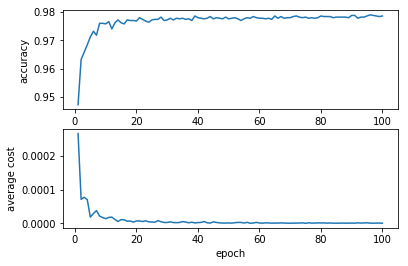

In [47]:
if __name__ == '__main__':
    net = Network(X_train, Y_train_oh, X_dev, Y_dev_oh, batch_size_train=128)
    net.run()